In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping 

In [2]:
# Load the DataFrame
df = pd.read_csv('/kaggle/input/mp-2-clean-dataset/CleanDataset/clean_and_merged_df.csv')

# Define the image directory
image_dir = '/kaggle/input/mp-2-clean-dataset/CleanDataset/Resized_Images/'

# Append the full path to imageid column
df['imageid'] = df['imageid'].apply(lambda x: os.path.join(image_dir, x))

In [3]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['glaucoma'], random_state=42)

In [4]:
# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Convert the 'glaucoma' column to strings
train_df['glaucoma'] = train_df['glaucoma'].astype(str)
val_df['glaucoma'] = val_df['glaucoma'].astype(str)

# Create training and validation data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='imageid',
    y_col='glaucoma',
    target_size=(224, 224),  # ResNet50 expects 224x224 images
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='imageid',
    y_col='glaucoma',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 1976 validated image filenames belonging to 2 classes.
Found 494 validated image filenames belonging to 2 classes.


In [5]:
# Step 1: Load the VGG16 model with pre-trained ImageNet weights, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
# Freeze the base model layers initially
base_model.trainable = False

# Step 2: Add custom layers on top of the base VGG16 model
x = base_model.output
x = Flatten()(x)  # Add global average pooling to reduce the spatial dimensions
x = Dense(1024, activation='relu')(x)  # Add a fully connected dense layer
predictions = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model for initial training with frozen base model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore model weights from the best epoch
)

In [8]:
# Step 3: Train the model with the custom layers (base model is frozen)
history = model.fit(
    train_generator,
    epochs=15,  # Train for a few epochs first
    validation_data=val_generator,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 50s 749ms/step - accuracy: 0.6963 - loss: 0.8559 - val_accuracy: 0.7753 - val_loss: 0.5290
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 385ms/step - accuracy: 0.7566 - loss: 0.5228 - val_accuracy: 0.7753 - val_loss: 0.4882
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 385ms/step - accuracy: 0.7647 - loss: 0.5231 - val_accuracy: 0.7773 - val_loss: 0.4664
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 386ms/step - accuracy: 0.7834 - loss: 0.4876 - val_accuracy: 0.7753 - val_loss: 0.4774
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 388ms/step - accuracy: 0.7744 - loss: 0.5050 - val_accuracy: 0.7874 - val_loss: 0.4715
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 383ms/step - accuracy: 0.7820 - loss: 0.4873 - val_accuracy: 0.7874 - val_loss: 0.4713
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 390ms/step - accuracy: 0.7723 - loss: 0.4958 - val_accuracy: 0.7733 - val_loss: 0.4625
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 384ms/step - accuracy: 0.7535 - loss: 0.5066 - val_accu

In [9]:
# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Loss : {loss}')
print(f'Validation Accuracy : {accuracy}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.7669 - loss: 0.4676
Validation Loss : 0.44539350271224976
Validation Accuracy : 0.7854251265525818


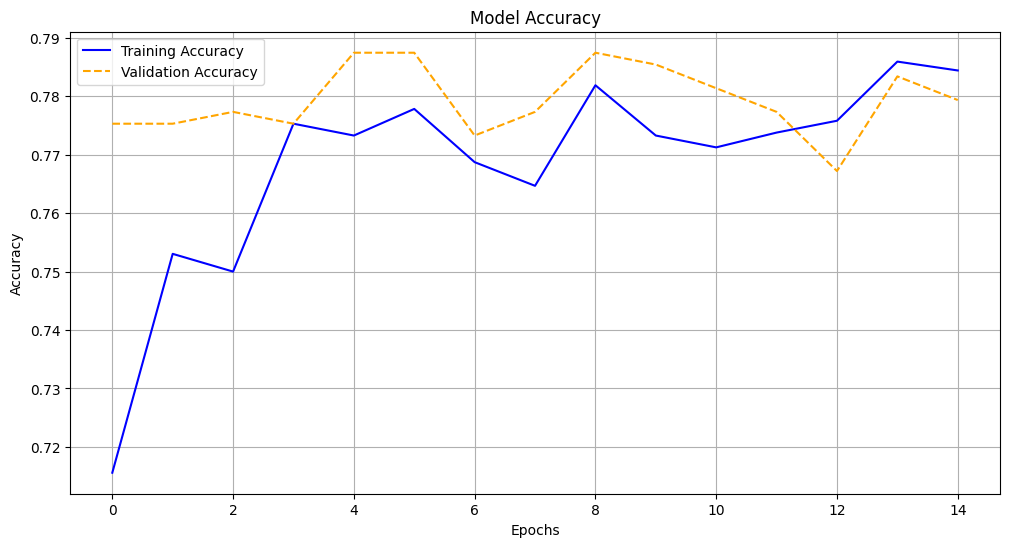

In [10]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid()
plt.show()

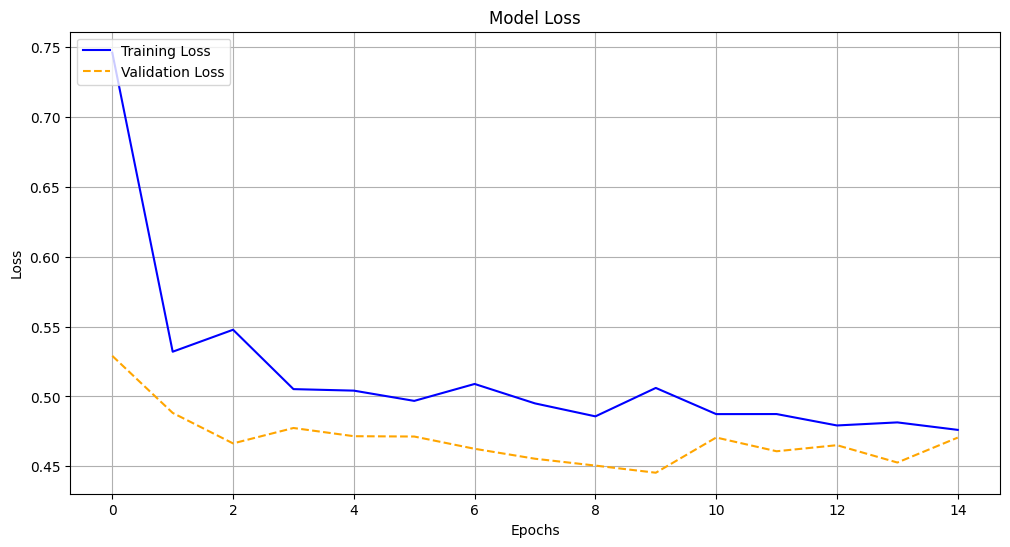

In [11]:
# Plotting Training and Validation Loss
plt.figure(figsize=(12, 6))

# Plot loss
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid()
plt.show()


In [12]:
model.save("/kaggle/working/MP-2_VGG16.h5")